In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner
import copy
import pickle
from astropy.io import ascii
from itertools import cycle

import matplotlib.gridspec as gridspec

%matplotlib inline

# Plotting code

In [2]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=3
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=12
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5


def makeCmap(hexColour,zeroColour='#FFFFFF'):
    r0,g0,b0=mpl.colors.hex2color(zeroColour)
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r0, r0),
                   (1.0, r, r)),
         'green': ((0.0, g0, g0),
                   (1.0, g, g)),
         'blue':  ((0.0, b0, b0),
                   (1.0, b, b))
        }
    cmap = mpl.colors.LinearSegmentedColormap(hexColour,cdict)
    return cmap


def makeGradient(hexColour):
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r, r),
                   (1.0, r, r)),
         'green': ((0.0, g, g),
                   (1.0, g, g)),
         'blue':  ((0.0, b, b),
                   (1.0, b, b)),
         'alpha':  ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0))
        }
    cmap = mpl.colors.LinearSegmentedColormap(hexColour,cdict)
    return cmap


def makePlotColours(mappableList,coloursList):
    """
    mappableArray = a list of discrete values, each corresponding to a unique color (zero-indexed)
    coloursList = list of desired colors. Ideally should be at least as many colours as there are unique
                  entries in mappableArray.
    """
    
    zidx = []
    uniqueMappableList = np.unique(mappableList)
    for j in range(len(mappableList)):
        for i,entry in enumerate(uniqueMappableList):
            if mappableList[j] == entry:
                zidx.append(i)
    
    zidx = np.array((zidx))
    uniqueVals = len(np.unique(zidx))
    
    cidx = 0
    colourMaps = []
    cycledColours = []
    for c in cycle(coloursList):
        colourMaps.append(makeGradient(c))
        cycledColours.append(c)
        cidx+=1
        if cidx > uniqueVals: 
            break
    
    blankCmap=makeGradient('#FFFFFF')
    colours = blankCmap(0.999*np.ones_like(zidx))

    for j in range(0,uniqueVals):
        colours[zidx==j] = colourMaps[j](0.999*np.ones_like(np.arange(0,len(zidx))[zidx==j]))

    return colourMaps,colours,cycledColours,list(uniqueMappableList)

In [3]:
def makePlot(ax, xdata, ydata, colours, xlabel, ylabel, sizes=100,
             legendTitle=None,legendEntries=None, legendColours=None,
             xlim=[], ylim=[],xscale="linear",yscale="linear",alpha=1):
    ax.scatter(xdata,ydata,c=colours,s=sizes,alpha=alpha)
    
    nonans = (np.isfinite(xdata) & np.isfinite(ydata))
    xdata=xdata[nonans]
    ydata=ydata[nonans]
    colours=colours[nonans]
    
    xmin = np.min(xdata[xdata > 0.])#.value
    xmax = np.max(xdata)#.value
    
    ymin = np.min(ydata[ydata > 0.])#.value
    ymax = np.max(ydata)#.value

    if not xlim:
        if xscale=="log":
            ax.set_xlim(0.1*xmin,10.*xmax)
        else:
            ax.set_xlim(0.95*xmin,1.05*xmax)
    else:
        ax.set_xlim(xlim)
        
    if not ylim:
        if yscale=="log":
            ax.set_ylim(0.1*ymin,10.*ymax)
        else:
            ax.set_ylim(0.95*ymin,1.05*ymax)
    else:
        ax.set_ylim(ylim)
    
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    
    ax.set_xlabel(xlabel,fontsize=24)
    ax.set_ylabel(ylabel,fontsize=24)
    ax.tick_params(labelsize=18)
    
    if legendEntries is not None:
        if xscale=="log":
            minx = 1.e-7*xmin
        else:
            minx = -100*xmin
                
        if yscale=="log":
            miny = 1.e-7*ymin
        else:
            miny = -100*ymin
            
        for i in range(0,len(legendEntries)):
            ax.scatter([minx,minx],[miny,miny],s=200,c=legendColours[i],label='{0}'.format(legendEntries[i]))

        leg=ax.legend(loc=0,ncol=1,frameon=False,fontsize=20,title=legendTitle)
        leg.get_title().set_fontsize('22')
    return 

# Planet data in usable format
## each planet object includes: [Teff, logg, [Fe/H], Rp/R*, P]

(38037, 2)


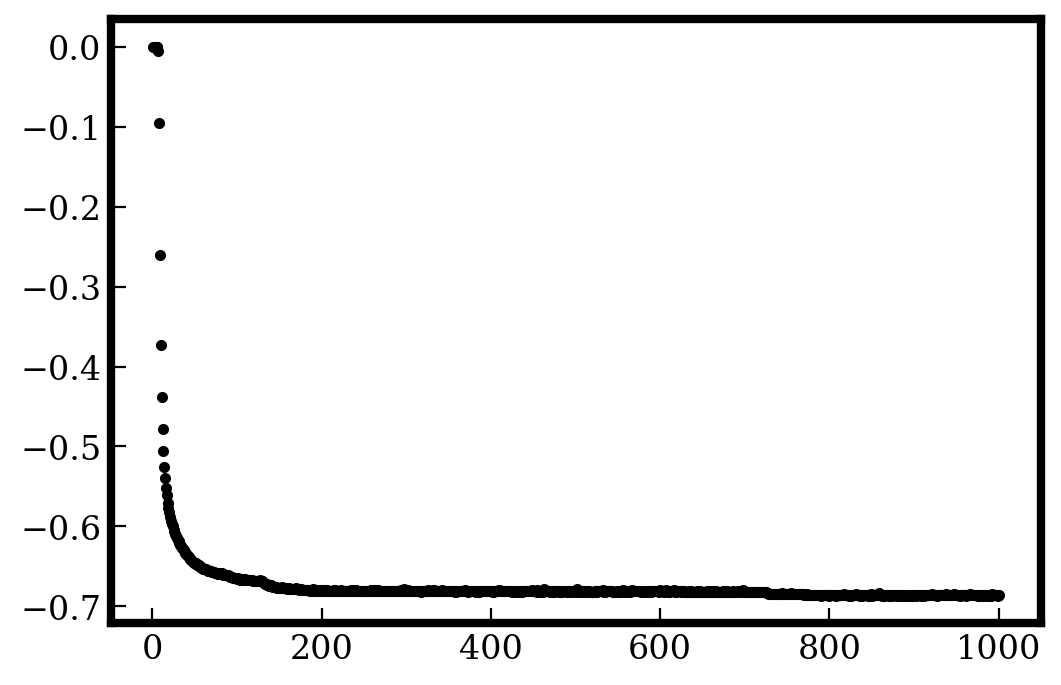

In [4]:
results = np.load("./simulatedPlanets/fake_twoRadiusPops_classprobs.npy")
idxs = np.load("./simulatedPlanets/fake_twoRadiusPops_idxs.npy")
losses = np.load("./simulatedPlanets/fake_twoRadiusPops_losses.npy")
print(np.shape(results))

plt.plot(losses[:,0],losses[:,1],'k.')
plt.show()

In [5]:
print(results)
#print(len(results[results[:,0]<=0.5]))
#print(len(results[results[:,0]>0.5]))
#print(np.max(results,axis=1))

[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [6]:
n_planet_features = 5

(38037, 5)
[1 1 0 ... 0 1 1]
(38037,)


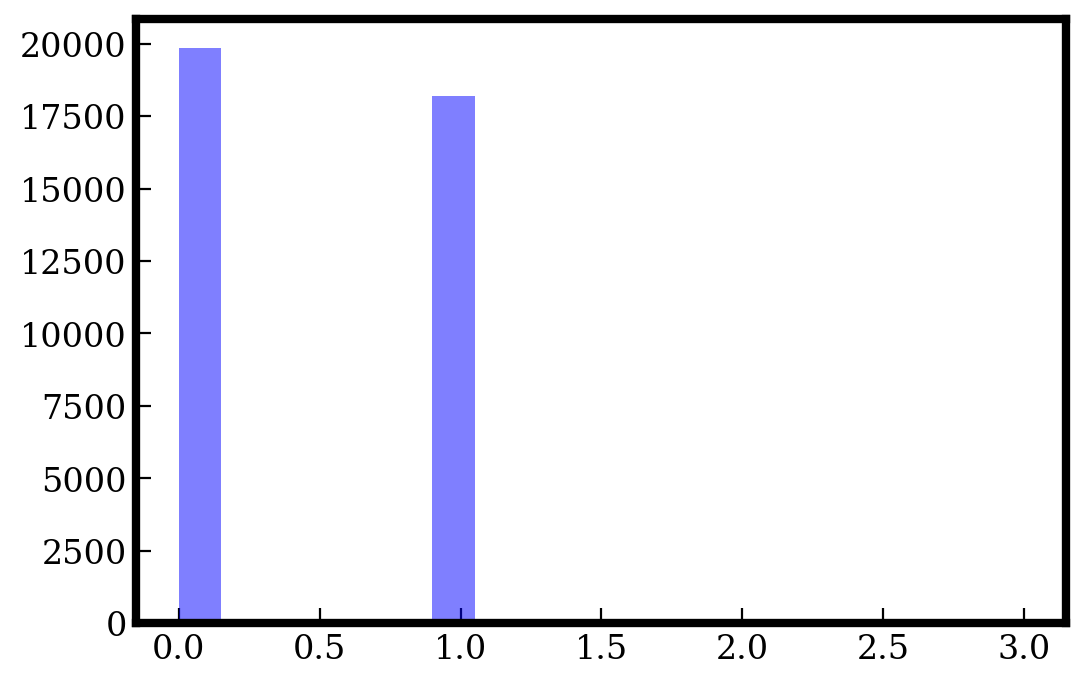

In [7]:
with open("simulatedPlanets/fake_twoRadiusPops.txt", "rb") as picklefile:
    systems = pickle.load(picklefile)

data = np.zeros((1,n_planet_features))

for i in range(len(systems)):
    sys = systems[i]
    for j in range(len(sys)):
        data = np.vstack((data,np.array(sys[j])))
        
data = data[1:][idxs]
print(np.shape(data))
    
bestClass = np.argmax(results,axis=1)
print(bestClass)
print(np.shape(bestClass))

#trueClass = np.load("./simulatedPlanets/fake_twoRadiusPops_truths.npy")
plt.hist(bestClass,bins=20,range=(0,3),color='b',alpha=0.5)
#plt.hist(trueClass,bins=20,range=(0,3),color='r',alpha=0.5)
plt.show()

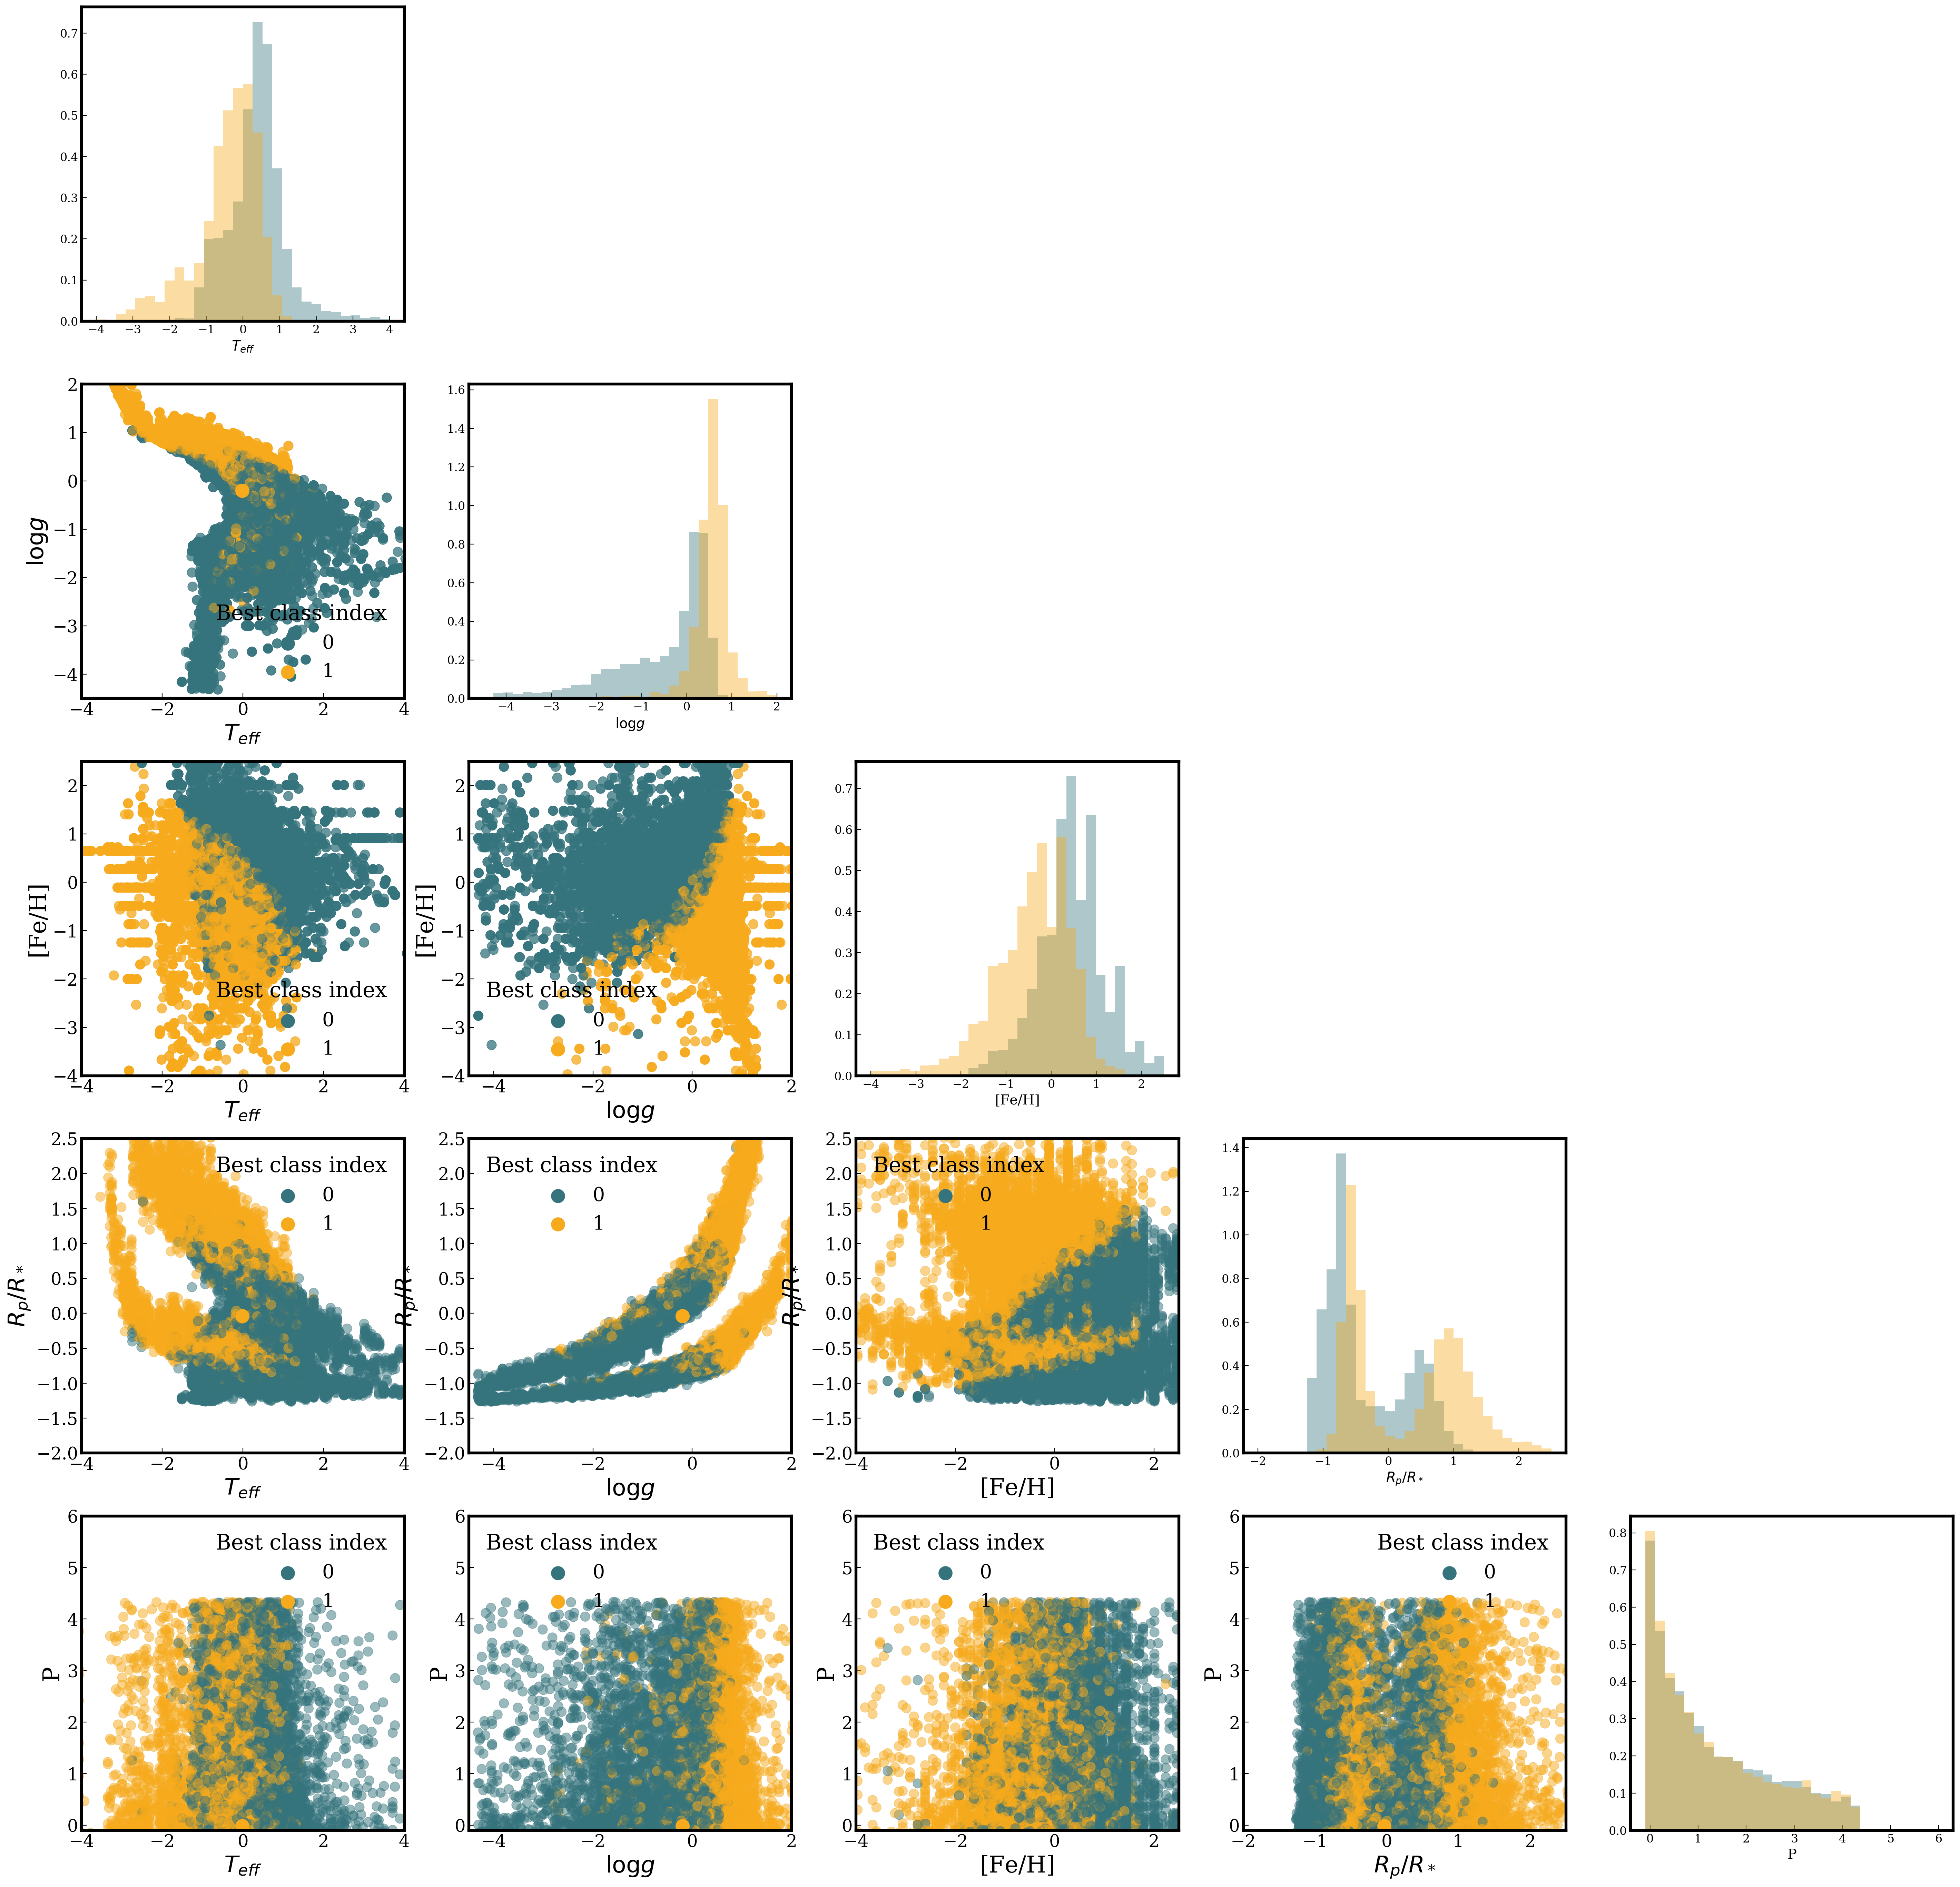

In [8]:
classColoursList = ['#36747D','#F6AA1C','#003049','#7A1809','#BF3E0B','#2E8B57','#EE4266','#540D6E']

class_colourMaps,class_colours,class_legendColours,class_legendEntries = makePlotColours(bestClass,classColoursList)

labels = [r'$T_{eff}$',r'$\log{g}$',r'[Fe/H]',r'$R_p/R_*$',r'P']
limits = [(3000,8000),(3.0,5.5),(-1.25,0.6),(0.0,0.3),(0,600)]
scaledLimits = [(-4,4),(-4.5,2),(-4,2.5),(-2,2.5),(-0.1,6.)]

#labels = [r'$R_p/R_*$']
#limits = [(0.0,0.3)]

fig = plt.figure(figsize=(7*n_planet_features,7*n_planet_features))
gs = gridspec.GridSpec(n_planet_features, n_planet_features)

for i in range(n_planet_features):
    for j in range(n_planet_features):
        if i>j:
            ax = plt.subplot(gs[i,j])
            makePlot(ax,
                    xdata=data[:,j],
                    ydata=data[:,i],
                    colours=class_colours,
                    xlim=scaledLimits[j],
                    ylim=scaledLimits[i],
                    legendTitle="Best class index",
                    legendEntries=class_legendEntries,
                    legendColours=class_legendColours,
                    #xscale="log",
                    #yscale="log",
                    xlabel=labels[j],
                    ylabel=labels[i],
                    alpha=0.5)
            
        if i==j:
            ax = plt.subplot(gs[i,j])
            for k in range(0,len(np.unique(bestClass))):
                ax.hist(data[:,i][bestClass==k],normed=True,bins=30,color=classColoursList[k],range=scaledLimits[i],alpha=0.4)
            ax.set_xlabel(labels[i])

plt.subplots_adjust(wspace=0.2,hspace=0.2)
#plt.show()
plt.savefig("./simulatedPlanets/fake_twoRadiusPops_results.png",fmt="png")

# Look at POS tagging results

In [9]:
posResults = np.load("../POStagger/example.w_classprobs.npy")
print(posResults)
print(np.argmax(posResults,axis=1))
words = ['chased','chased','chased','cat','the','dog','dog','rat','the','the','cat','the','the','the','rat'] # as encoded in Y1
posTruths = ['V', 'V', 'V', 'N', 'D', 'N', 'N', 'N', 'D', 'D', 'N', 'D', 'D', 'D', 'N']
posTruthIdxs = np.array((0, 0, 0, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1))
print(posTruthIdxs)

# So everything appears to be working fine, except that the ordering in Y1 is not intuitive, and I should double-check
# that it's right in the planet case.

[[0.81817073 0.05507379 0.12675548]
 [0.81817073 0.05507379 0.12675548]
 [0.81817073 0.05507379 0.12675548]
 [0.45893332 0.48625085 0.05481588]
 [0.03423147 0.04163561 0.92413294]
 [0.18549669 0.78633541 0.02816791]
 [0.18549669 0.78633541 0.02816791]
 [0.32601541 0.61282152 0.06116307]
 [0.03423147 0.04163561 0.92413294]
 [0.03423147 0.04163561 0.92413294]
 [0.45893332 0.48625085 0.05481588]
 [0.03423147 0.04163561 0.92413294]
 [0.03423147 0.04163561 0.92413294]
 [0.03423147 0.04163561 0.92413294]
 [0.32601544 0.61282146 0.06116306]]
[0 0 0 1 2 1 1 1 2 2 1 2 2 2 1]
[0 0 0 1 2 1 1 1 2 2 1 2 2 2 1]
